In [2]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import sklearn.metrics as metrics
matplotlib.rcParams['figure.figsize'] = [9, 6]

4. Importing the dataset: 



In [3]:
#loadig the MNIST dataset using the tensorflow_datasets.load function which takes 14 arguments: 
"""
tfds.load(
    name: str,
    *,
    split: Optional[Tree[splits_lib.SplitArg]] = None,
    data_dir: Union[None, str, os.PathLike] = None,
    batch_size: tfds.typing.Dim = None,
    shuffle_files: bool = False,
    download: bool = True,
    as_supervised: bool = False,
    decoders: Optional[TreeDict[decode.partial_decode.DecoderArg]] = None,
    read_config: Optional[tfds.ReadConfig] = None,
    with_info: bool = False,
    builder_kwargs: Optional[Dict[str, Any]] = None,
    download_and_prepare_kwargs: Optional[Dict[str, Any]] = None,
    as_dataset_kwargs: Optional[Dict[str, Any]] = None,
    try_gcs: bool = False
)


"""
train_data, val_data, test_data = tfds.load("mnist", 
                                            split=['train[10000:]', 'train[0:10000]', 'test'],
                                            batch_size=128, as_supervised=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
#EXERCISE: 
#From the above decsription of the arguments of the tensorflow load function, define the remaining parameters and set their values 

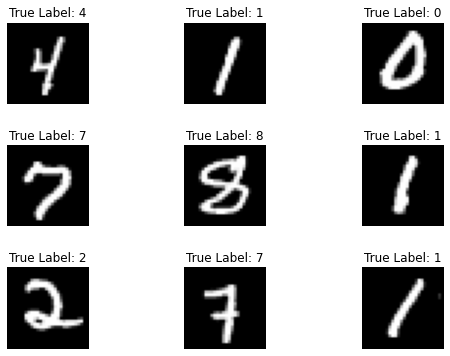

In [5]:
#Specification of a variable "x_Visulaization" and "y_Visualization" 
x_Visualization, y_Visualization = tfds.load("mnist", split=['train[:1500]'], batch_size=-1, as_supervised=True)[0]
# the "tf.squeeze" function is a prebuild function in tensorflow that removes dimensions of size 1 from the shape of a tensor.
x_Visualization = tf.squeeze(x_Visualization, axis=3)

#Plotting the tensor 
for i in range(9):
    plt.subplot(3,3,1+i)
    plt.axis('off')
    plt.imshow(x_Visualization[i], cmap='gray')
    plt.title(f"True Label: {y_Visualization[i]}")
    #To adjust the subplot layout parameters (the specific parameter hspace: The height of the padding between subplots, as a fraction of the average Axes height.)
    plt.subplots_adjust(hspace=.5)

In [6]:
#EXERCISE: 
#Using the same tensors (x_Visualization and y_Visualization) display 10 different versions of the number 3

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


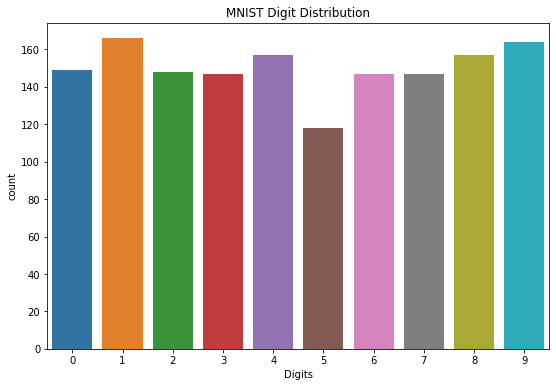

In [7]:
#Counting the occurence of a digit in the dataset. 
sns.countplot(y_Visualization.numpy());
plt.xlabel('Digits')
plt.title("MNIST Digit Distribution");

In [8]:
#The defined function below (preprocess) returns the reshaped tensor (that have the same type, in the same order) to the specified shape : [-1, 784]
def preprocess(x, y):
  # Reshaping the data using reshape function from tensorflow: 
  x = tf.reshape(x, shape=[-1, 784])
  # Rescaling the data
  x = x/255
  return x, y
#Applying the "preprocess" to the train_data and val_data
train_data, val_data = train_data.map(preprocess), val_data.map(preprocess)

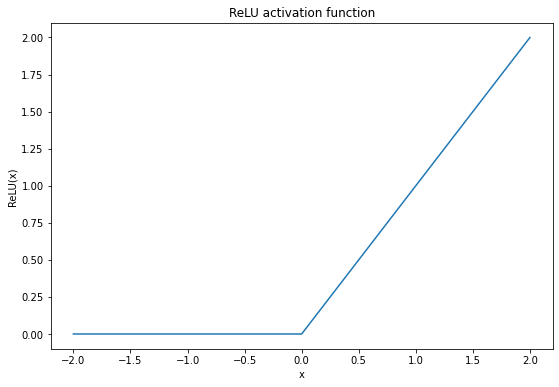

In [9]:
#linspace generates evenly-spaced values in an interval along a given axis.
#-2 being the start in the range, 2 the final in the range and 201 the number of values to generate
x = tf.linspace(-2, 2, 201)
#Changing the type of the generated values to float32
x = tf.cast(x, tf.float32)
#Applying ReLu activation function on the generated values 
plt.plot(x, tf.nn.relu(x));
#Display the ReLu function 
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.title('ReLU activation function');

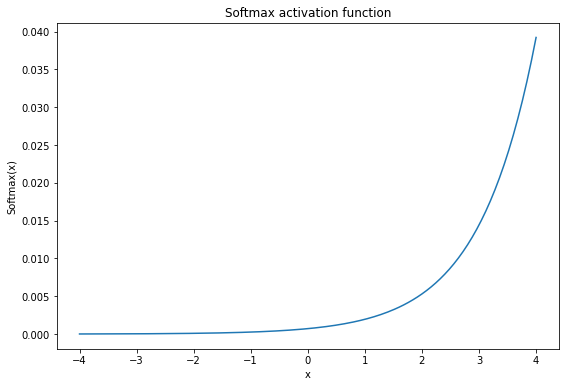

In [10]:
#linspace generates evenly-spaced values in an interval along a given axis.
#-4 being the start in the range, 4 the final in the range and 201 the number of values to generate
x = tf.linspace(-4, 4, 201)
#Casting the type of the generated values to float32
x = tf.cast(x, tf.float32)
#Applying the softmax function 
plt.plot(x, tf.nn.softmax(x, axis=0));
#Displaying the function : 
plt.xlabel('x')
plt.ylabel('Softmax(x)')
plt.title('Softmax activation function');

In [11]:
def xavier_init(shape):
  # Computes the xavier initialization values for a weight matrix
  in_dim, out_dim = shape
  xavier_lim = tf.sqrt(6.)/tf.sqrt(tf.cast(in_dim + out_dim, tf.float32))
  weight_vals = tf.random.uniform(shape=(in_dim, out_dim), 
                                  minval=-xavier_lim, maxval=xavier_lim, seed=22)
  return weight_vals

6.2. Building the model: 

In [12]:
#Defining the Dense Layer class : 
"""
The dense layer is the regular deeply connected neural network layer. 
Dense layer does the below operation on the input and return the output.

**
output = activation(dot(input, kernel) + bias)
**

Where: 

- input represent the input data

- kernel represent the weight data

- dot represent numpy dot product of all input and its corresponding weights

- bias represent a biased value used in machine learning to optimize the model

- activation represent the activation function.

"""
class DenseLayer(tf.Module):

  def __init__(self, out_dim, weight_init=xavier_init, activation=tf.identity):
    # Initialize the dimensions and activation functions
    self.out_dim = out_dim
    self.weight_init = weight_init
    self.activation = activation
    self.built = False

  def __call__(self, x):
    if not self.built:
      # Infer the input dimension based on first call
      self.in_dim = x.shape[1]
      # Initialize the weights and biases using Xavier scheme
      self.w = tf.Variable(xavier_init(shape=(self.in_dim, self.out_dim)))
      self.b = tf.Variable(tf.zeros(shape=(self.out_dim,)))
      self.built = True
    # Compute the forward pass
    z = tf.add(tf.matmul(x, self.w), self.b)
    return self.activation(z)

In [13]:
#Building the MLP class: 
class MLP(tf.Module):

  def __init__(self, layers):
    self.layers = layers
   
  @tf.function
  def __call__(self, x, preds=False): 
    # Execute the model's layers sequentially
    for layer in self.layers:
      x = layer(x)
    return x

In [14]:
#Defining each layer of our MLP model : 
#Two hidden layers , the first of size 700 , the second of size 500
hidden_layer_1_size = 700
hidden_layer_2_size = 500
#Defining the output layer of size 10
output_size = 10

mlp_model = MLP([
    DenseLayer(out_dim=hidden_layer_1_size, activation=tf.nn.relu),
    DenseLayer(out_dim=hidden_layer_2_size, activation=tf.nn.relu),
    DenseLayer(out_dim=output_size)])

In [15]:
#EXERCISE: 
#1. Using the same size of hidden layers, apply in three different version of the code block above : 
"""
1.1. The Sigmoid function 
1.2. The Softmax function 
1.3. The Elu function 

"""
#2. Now change the size of both layers to 900 for the first and 700 for the second and then apply chnages as in (1). 

'\n1.1. The Sigmoid function \n1.2. The Softmax function \n1.3. The Elu function \n\n'

7. Evaluation metrics: 


7.1. Loss function: A loss function is a function that compares the target and predicted output values; measures how well the neural network models the training data. When training, we aim to minimize this loss between the predicted and target outputs.




In the case of classification Loss Functions : given an input, the neural network produces a vector of probabilities of the input belonging to various pre-set categories — can then select the category with the highest probability of belonging; Ex. Binary Cross-Entropy, Categorical Cross-Entropy. 


Please check the references section for more information.

In [16]:
def cross_entropy_loss(y_pred, y):
  # Compute cross entropy loss with a sparse operation
  sparse_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(sparse_ce)

def accuracy(y_pred, y):
  # Compute accuracy after extracting class predictions
  class_preds = tf.argmax(tf.nn.softmax(y_pred), axis=1)
  is_equal = tf.equal(y, class_preds)
  return tf.reduce_mean(tf.cast(is_equal, tf.float32))

In [17]:
#EXERCISE: 
#In the code block, we computed the sparse softmax cross entropy between logits and labels. 
#In the following, write a code that defines the same function 'cross_entropy_loss' but using 'weighted_cross_entropy_with_logits' unstead of 'sparse_softmax_cross_entropy_with_logits'. 


In [18]:
def train_step(x_batch, y_batch, loss, acc, model, optimizer):
  # Update the model state given a batch of data
  with tf.GradientTape() as tape:
    y_pred = model(x_batch)
    batch_loss = loss(y_pred, y_batch)
  batch_acc = acc(y_pred, y_batch)
  grads = tape.gradient(batch_loss, model.variables)
  optimizer.apply_gradients(grads, model.variables)
  return batch_loss, batch_acc

def val_step(x_batch, y_batch, loss, acc, model):
  # Evaluate the model on given a batch of validation data
  y_pred = model(x_batch)
  batch_loss = loss(y_pred, y_batch)
  batch_acc = acc(y_pred, y_batch)
  return batch_loss, batch_acc
  
def train_model(mlp, train_data, val_data, loss, acc, optimizer, epochs):
  # Initialize data structures
  train_losses, train_accs = [], []
  val_losses, val_accs = [], []

  # Format training loop and begin training
  for epoch in range(epochs):
    batch_losses_train, batch_accs_train = [], []
    batch_losses_val, batch_accs_val = [], []

    # Iterate over the training data
    for x_batch, y_batch in train_data:
      # Compute gradients and update the model's parameters
      batch_loss, batch_acc = train_step(x_batch, y_batch, loss, acc, mlp, optimizer)
      # Keep track of batch-level training performance
      batch_losses_train.append(batch_loss)
      batch_accs_train.append(batch_acc)

    # Iterate over the validation data
    for x_batch, y_batch in val_data:
      batch_loss, batch_acc = val_step(x_batch, y_batch, loss, acc, mlp)
      batch_losses_val.append(batch_loss)
      batch_accs_val.append(batch_acc)

    # Keep track of epoch-level model performance
    train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
    val_loss, val_acc = tf.reduce_mean(batch_losses_val), tf.reduce_mean(batch_accs_val)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Epoch: {epoch}")
    print(f"Training loss: {train_loss:.3f}, Training accuracy: {train_acc:.3f}")
    print(f"Validation loss: {val_loss:.3f}, Validation accuracy: {val_acc:.3f}")
  return train_losses, train_accs, val_losses, val_accs

In [19]:
class Adam:

  def __init__(self, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, ep=1e-7):
      # Initialize optimizer parameters and variable slots
      self.beta_1 = beta_1
      self.beta_2 = beta_2
      self.learning_rate = learning_rate
      self.ep = ep
      self.t = 1.
      self.v_dvar, self.s_dvar = [], []
      self.built = False
 
  def apply_gradients(self, grads, vars):
      # Initialize variables on the first call
      if not self.built:
        for var in vars:
          v = tf.Variable(tf.zeros(shape=var.shape))
          s = tf.Variable(tf.zeros(shape=var.shape))
          self.v_dvar.append(v)
          self.s_dvar.append(s)
        self.built = True
      # Update the model variables given their gradients
      for i, (d_var, var) in enumerate(zip(grads, vars)):
        self.v_dvar[i].assign(self.beta_1*self.v_dvar[i] + (1-self.beta_1)*d_var)
        self.s_dvar[i].assign(self.beta_2*self.s_dvar[i] + (1-self.beta_2)*tf.square(d_var))
        v_dvar_bc = self.v_dvar[i]/(1-(self.beta_1**self.t))
        s_dvar_bc = self.s_dvar[i]/(1-(self.beta_2**self.t))
        var.assign_sub(self.learning_rate*(v_dvar_bc/(tf.sqrt(s_dvar_bc) + self.ep)))
      self.t += 1.
      return 

In [20]:
class SGD:
    def __init__(self, learning_rate=0.01, momentum=0.0):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.velocities = []
        self.built = False

    def apply_gradients(self, grads, vars):
        if not self.built:
            for var in vars:
                self.velocities.append(tf.zeros_like(var))
            self.built = True
        for i, (grad, var) in enumerate(zip(grads, vars)):
            self.velocities[i] = self.momentum * self.velocities[i] - self.learning_rate * grad
            var.assign_add(self.velocities[i])


In [21]:
class RMSprop:
    def __init__(self, learning_rate=0.001, decay_rate=0.9, epsilon=1e-7):
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.epsilon = epsilon
        self.mean_squares = []
        self.built = False

    def apply_gradients(self, grads, vars):
        if not self.built:
            for var in vars:
                self.mean_squares.append(tf.zeros_like(var))
            self.built = True
        for i, (grad, var) in enumerate(zip(grads, vars)):
            self.mean_squares[i] = self.decay_rate * self.mean_squares[i] + (1 - self.decay_rate) * tf.square(grad)
            var.assign_sub(self.learning_rate * grad / (tf.sqrt(self.mean_squares[i]) + self.epsilon))


In [22]:
class Adagrad:
    def __init__(self, learning_rate=0.01, epsilon=1e-7):
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.sum_squares = []
        self.built = False

    def apply_gradients(self, grads, vars):
        if not self.built:
            for var in vars:
                self.sum_squares.append(tf.zeros_like(var))
            self.built = True
        for i, (grad, var) in enumerate(zip(grads, vars)):
            self.sum_squares[i] += tf.square(grad)
            var.assign_sub(self.learning_rate * grad / (tf.sqrt(self.sum_squares[i]) + self.epsilon))


In [23]:
def relu(x):
    return tf.nn.relu(x)
def sigmoid(x):
    return tf.math.sigmoid(x)
def tanh(x):
    return tf.math.tanh(x)
def leaky_relu(x, alpha=0.2):
    return tf.maximum(x, alpha*x)
def swish(x, beta=1.0):
    return x * tf.math.sigmoid(beta * x)
def softmax(x):
    return tf.nn.softmax(x)



In [24]:
#Defining each layer of our MLP model : 
#Two hidden layers , the first of size 700 , the second of size 500
hidden_layer_1_size = 700
hidden_layer_2_size = 500
#Defining the output layer of size 10
output_size = 10

mlp_model = MLP([
    DenseLayer(out_dim=hidden_layer_1_size, activation=tf.nn.relu),
    DenseLayer(out_dim=hidden_layer_2_size, activation=tf.nn.relu),
    DenseLayer(out_dim=output_size,activation=tf.nn.softmax)])

In [ ]:
optimizers=[swish,leaky_relu,relu,tanh,sigmoid,softmax]

output=[]
for i in optimizers:
  for j in [100,200,300,400,500,600,700]:
    for k in [100,200,300,400,500,600,700]:
      hidden_layer_1_size = j
      hidden_layer_2_size = k
      mlp_model = MLP([
      DenseLayer(out_dim=hidden_layer_1_size, activation=tf.nn.relu),
      DenseLayer(out_dim=hidden_layer_2_size, activation=tf.nn.relu),
      DenseLayer(out_dim=output_size,activation=i)])
      train_losses, train_accs, val_losses, val_accs = train_model(mlp_model, train_data, val_data, 
                                                             loss=cross_entropy_loss, acc=accuracy,
                                                             optimizer=Adam(), epochs=5)
      output.append({"train_losses":train_losses,"train_accs":train_accs,"val_losses":val_losses,"val_accs":val_accs,
                     "hidden_layer_1_size":hidden_layer_1_size,"hidden_layer_2_size":hidden_layer_2_size,"optimizer":i

          }
      )
      



In [26]:
# sort the list of models based on the val_accs in descending order
sorted_models = sorted(output, key=lambda x: x["val_accs"], reverse=True)

# print the sorted models
for model in sorted_models:
    print(f"Hyperparameters for Model with Validation Accuracy of {model['val_accs']}:")
    print(f"Hidden Layer 1 Size: {model['hidden_layer_1_size']}")
    print(f"Hidden Layer 2 Size: {model['hidden_layer_2_size']}")
    print(f"Optimizer: {model['optimizer']}")
    print("\n")

Hyperparameters for Model with Validation Accuracy of [<tf.Tensor: shape=(), dtype=float32, numpy=0.9647943>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9725079>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9752769>, <tf.Tensor: shape=(), dtype=float32, numpy=0.97448575>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9739913>]:
Hidden Layer 1 Size: 500
Hidden Layer 2 Size: 600
Optimizer: <function swish at 0x7f27e0435700>


Hyperparameters for Model with Validation Accuracy of [<tf.Tensor: shape=(), dtype=float32, numpy=0.964102>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9712223>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9769581>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9743869>, <tf.Tensor: shape=(), dtype=float32, numpy=0.97547466>]:
Hidden Layer 1 Size: 700
Hidden Layer 2 Size: 600
Optimizer: <function swish at 0x7f27e0435700>


Hyperparameters for Model with Validation Accuracy of [<tf.Tensor: shape=(), dtype=float32, numpy=0.96390426>, <tf.Tensor: shape=(), dtype=fl